In [6]:
# ENV["CONDA_ENV"]="conda_jl"
# ENV["CONDA_JL_HOME"]="$(ENV["HOME"])/.conda/envs/$(ENV["CONDA_ENV"])"
# ENV["PYTHON"]="$(ENV["CONDA_JL_HOME"])/bin/python"

In [1]:
using DrWatson
@quickactivate "TriangularHubbard"
using TriangularHubbard

  Activating project at `/gpfs/research/changlani/Lee_project/TriangularHubbard`


In [3]:
using PyCall
using PyPlot
mpl = pyimport("matplotlib")

PyObject <module 'matplotlib' from '/gpfs/home/kyungminlee_42/.conda/envs/conda_jl/lib/python3.9/site-packages/matplotlib/__init__.py'>

In [4]:
using LinearAlgebra
using JSON
using DBInterface
using SQLite
using DataFrames
using DataFramesMeta

In [5]:
shape_str = "(3,0)x(0,3)"

"(3,0)x(0,3)"

In [6]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 7 entries:
  "shape"                 => Any[Any[3, 0], Any[0, 3]]
  "momentums"             => Any[Dict{String, Any}("fractional_coordinates"=>An…
  "point_group_symmetry"  => "6mm"
  "supercell"             => Dict{String, Any}("sites"=>Any[Dict{String, Any}("…
  "equivalent_site_pairs" => Any[Any[Any[1, 1], Any[2, 2], Any[3, 3], Any[4, 4]…
  "unitcell"              => Dict{String, Any}("sites"=>Any[Dict{String, Any}("…
  "bravais_coordinates"   => Any[Any[0, 0], Any[1, 0], Any[2, 0], Any[0, 1], An…

In [7]:
shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
reciprocallatticevectors = hcat(jsondata["unitcell"]["reciprocallatticevectors"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end

In [8]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, n_sites)
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end        

getrealspacemap (generic function with 1 method)

In [9]:
phases = cis.(-2π * momentums' * sitecoordinates)
# phases2 = cis.(-2π * fractionalmomentums' * bravaiscoordinates)
;

In [10]:
realspacemap_test = ones(Float64, (n_sites, 1))
abs2.(phases * realspacemap_test)

9×1 Matrix{Float64}:
 81.0
  4.782469237902384e-30
  1.8797076257219422e-29
  8.874685183736383e-31
  2.0954117794933126e-31
  2.297557386456197e-29
  4.992010415851715e-30
  1.1093356479670479e-29
  1.232595164407831e-30

In [29]:
# fig = PyPlot.figure(figsize=(8,4))
# ax = fig.add_subplot(1,2,1)
# ax.plot(momentums[1,:], momentums[2,:], "o")
# ax.set_aspect(1.0)
# ax = fig.add_subplot(1,2,2)
# ax.plot(sitecoordinates[1,:], sitecoordinates[2,:], "o")
# ax.set_aspect(1.0)

In [31]:
conn = DBInterface.connect(SQLite.DB, datadir("curie", shape_str, "sectors.sqlite3"))
df = DataFrame(DBInterface.execute(conn, """
        SELECT
          S.idx, nup, ndn, tii, pii, pic, dim, 
          D.hopping, D.interaction, D.temperature,
          E.base_energy, D.partition, D.energy, D.energy_squared, D.spin_correlation
        FROM dense_results AS D
        JOIN sectors AS S USING(idx)
        JOIN energy_shifts AS E USING(idx, hopping, interaction);
    """))
df2 = DataFrame(DBInterface.execute(conn, """
        SELECT
          S.idx, nup, ndn, tii, pii, pic, dim, 
          D.hopping, D.interaction, D.temperature,
          E.base_energy, D.partition, D.energy, D.energy_squared, D.spin_correlation
        FROM sparse_results_collection AS D
        JOIN sectors AS S USING(idx)
        JOIN sparse_energy_shifts AS E USING(idx, hopping, interaction);
        """))
close(conn)

In [13]:
names(df)

15-element Vector{String}:
 "idx"
 "nup"
 "ndn"
 "tii"
 "pii"
 "pic"
 "dim"
 "hopping"
 "interaction"
 "temperature"
 "base_energy"
 "partition"
 "energy"
 "energy_squared"
 "spin_correlation"

In [34]:
names(df2)

15-element Vector{String}:
 "idx"
 "nup"
 "ndn"
 "tii"
 "pii"
 "pic"
 "dim"
 "hopping"
 "interaction"
 "temperature"
 "base_energy"
 "partition"
 "energy"
 "energy_squared"
 "spin_correlation"

In [14]:
first(df, 5)

5×15 DataFrame
 Row │ idx    nup    ndn    tii    pii    pic    dim    hopping  interaction   ⋯
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Float64  Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1661      5      9      2      1      1      6      1.0         20.0   ⋯
   2 │  1661      5      9      2      1      1      6      1.0         20.0
   3 │  1661      5      9      2      1      1      6      1.0         20.0
   4 │  1661      5      9      2      1      1      6      1.0         20.0
   5 │  1661      5      9      2      1      1      6      1.0         20.0   ⋯
                                                               6 columns omitted

In [15]:
df[!, :charge] = (df[!, :nup] + df[!, :ndn])
df[!, :Sz] = 0.5 .* (df[!, :nup] - df[!, :ndn])
df[!, :Sz2] = df[!, :Sz].^2
;

In [16]:
rmaps = Vector{Float64}[]
for s in df[!, :spin_correlation]
    m = JSON.parse(s)
    replace!(m, nothing=>NaN)
    push!(rmaps, getrealspacemap(m))
end
rmaps = hcat(rmaps...)
kmaps = phases * rmaps

9×270320 Matrix{ComplexF64}:
  0.444444+0.0im          …  0.0277778+0.0im  0.0277778+0.0im
 0.0740741-7.99471e-17im     0.0277778+0.0im  0.0277778+0.0im
 0.0740741-1.70795e-16im     0.0277778+0.0im  0.0277778+0.0im
 0.0740741-2.82052e-17im     0.0277778+0.0im  0.0277778+0.0im
 0.0555556-2.50786e-17im     0.0277778+0.0im  0.0277778+0.0im
 0.0740741+2.13156e-16im  …  0.0277778+0.0im  0.0277778+0.0im
 0.0740741-9.0784e-17im      0.0277778+0.0im  0.0277778+0.0im
 0.0740741+1.47081e-16im     0.0277778+0.0im  0.0277778+0.0im
 0.0555556-6.22144e-17im     0.0277778+0.0im  0.0277778+0.0im

In [17]:
df[!, :SzSz0] = real.(kmaps[1,:]);

In [18]:
describe(df)

19×7 DataFrame
 Row │ variable          mean     min            median   max                  ⋯
     │ Symbol            Union…   Any            Union…   Any                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ idx               1400.68  1              1400.5   2773                 ⋯
   2 │ nup               4.5      0              4.5      9
   3 │ ndn               4.5      0              4.5      9
   4 │ tii               4.48387  1              5.0      9
   5 │ pii               2.4      1              2.0      6                    ⋯
   6 │ pic               1.13871  1              1.0      2
   7 │ dim               105.703  1              25.5     888
   8 │ hopping           1.0      1.0            1.0      1.0
   9 │ interaction       20.0     20.0           20.0     20.0                 ⋯
  10 │ temperature       4.63716  0.01           4.6      10.0
  11 │ base_energy       27.2685  -11.0972       0.0      180.0
  12 │ partition         6.06261  1.0            2.57703  64.6869
  13 │ energy            41.7142  0.0            5.44967  911.333              ⋯
  14 │ energy_squared    740.59   0.0            36.5607  25135.9
  15 │ spin_correlation           [0.0,0.0,0.0]           [9.983525554466034,-
  16 │ charge            9.0      0              9.0      18
  17 │ Sz                0.0      -4.5           0.0      4.5                  ⋯
  18 │ Sz2               3.56855  0.0            2.25     20.25
  19 │ SzSz0             10.9361  -4.996e-14     6.99204  85.2335
                                                               3 columns omitted

In [ ]:
select!(df, Not(:spin_correlation));

In [22]:
names(df)

18-element Vector{String}:
 "idx"
 "nup"
 "ndn"
 "tii"
 "pii"
 "pic"
 "dim"
 "hopping"
 "interaction"
 "temperature"
 "base_energy"
 "partition"
 "energy"
 "energy_squared"
 "charge"
 "Sz"
 "Sz2"
 "SzSz0"

In [23]:
temperatures = unique(sort(df[!, :temperature]));
# temperatures = temperatures[ temperatures .>= 0.1];

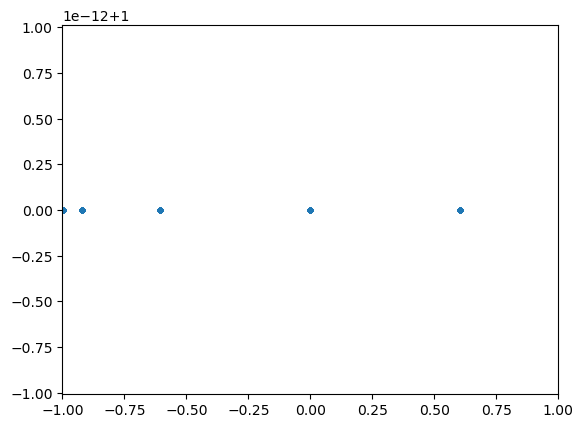

(-1.0, 1.0)

In [24]:
PyPlot.plot(df.base_energy, df.SzSz0 ./ (df.Sz2 .* df.partition), ".")
PyPlot.xlim(-1,1)

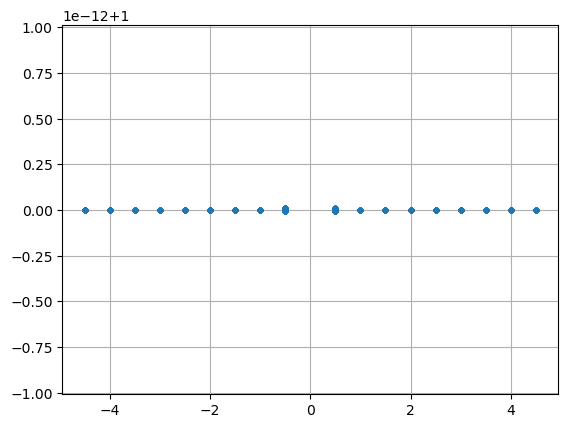

In [25]:
PyPlot.plot(df.Sz, df.SzSz0 ./ (df.Sz2 .* df.partition), ".")
PyPlot.grid()

In [26]:
@show any(ismissing, df[!, :base_energy])
@show any(isnothing, df[!, :base_energy])
@show any(isnan, df[!, :base_energy])
;

any(ismissing, df[!, :base_energy]) = false
any(isnothing, df[!, :base_energy]) = false
any(isnan, df[!, :base_energy]) = false


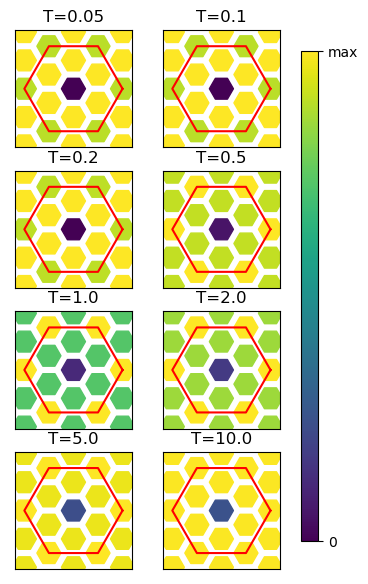

2-element Vector{PyObject}:
 PyObject Text(1, 0, '0')
 PyObject Text(1, 1, 'max')

In [234]:
fig = PyPlot.figure(figsize=(3.5, 7))
maxval = 0.0
ax = nothing
img = nothing


for i in 1:8
    j = select_indices[i]
    T, Sq = results[j]
    ax = fig.add_subplot(4,2,i)
    k0 = momentums .* 2π
    G = reciprocallatticevectors
    v0 = abs2.(Sq)
    k = Matrix{Float64}(undef, (2,0))
    v = Vector{Float64}(undef, 0)
    for R1 in [-1,0,1], R2 in [-1,0,1]
        R = [R1;R2]
        k = hcat(k, broadcast(+, k0, G * R))
        v = vcat(v, v0)
    end
    img = ax.scatter(k[1,:], k[2,:], s=300, c=mpl.cm.viridis(v ./ maximum(v)), marker="H")
    ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_aspect(1.0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("T=$(T)")
end
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
# cbar_ax.set_yticks([0, 1])
cbar_ax.set_yticklabels(["0", "max"])

In [125]:
reciprocallattice = hcat((reciprocallatticevectors * [R1, R2]  for R1 in [-1,0,1] for R2 in [-1,0,1])...)

2×9 Matrix{Float64}:
  -6.28319  -6.28319  -6.28319  …  0.0      6.28319  6.28319   6.28319
 -10.8828   -3.6276    3.6276      7.2552  -3.6276   3.6276   10.8828

In [128]:
sp = pyimport("scipy")
pyimport("scipy.spatial")

PyObject <module 'scipy.spatial' from '/gpfs/home/kyungminlee_42/.pyenv/versions/conda_jl/lib/python3.7/site-packages/scipy/spatial/__init__.py'>

In [133]:
voro = sp.spatial.Voronoi(reciprocallattice')

PyObject <scipy.spatial.qhull.Voronoi object at 0x2b5ad6fd9750>

In [151]:
p0 = [4π/3, 0]
R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
zone_boundary = [p0]
p = p0
for i in 1:5
    p = R * p
    push!(zone_boundary, p)
end
push!(zone_boundary, p0)
zone_boundary = hcat(zone_boundary...)

2×7 Matrix{Float64}:
 4.18879  2.0944  -2.0944  -4.18879      -2.0944   2.0944  4.18879
 0.0      3.6276   3.6276   1.51297e-15  -3.6276  -3.6276  0.0

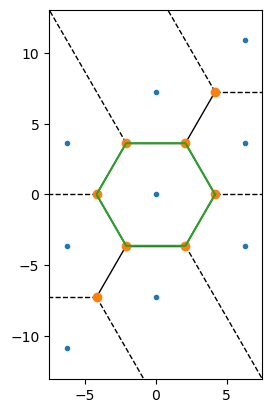

In [152]:

sp.spatial.voronoi_plot_2d(voro)
ax = PyPlot.gca()
# ax.plot([0,4π/3], [0,0])
ax.set_aspect(1.0)

In [137]:
voro.regions

10-element Vector{Vector}:
 Any[]
 [1, 0, -1]
 [4, -1, 2, 3]
 [4, -1]
 [4, -1, 0, 3]
 [7, -1, 5, 6]
 [-1, 2, 5]
 [6, 1, 0, 3, 2, 5]
 [7, -1]
 [7, -1, 1, 6]

In [138]:
voro.ridge_points

16×2 Matrix{Int32}:
 6  3
 6  4
 6  7
 1  2
 1  4
 1  0
 1  3
 0  3
 3  4
 5  2
 5  4
 5  8
 5  7
 2  4
 4  7
 8  7

In [140]:
voro.vertices

8×2 Matrix{Float64}:
  2.0944   -3.6276
  4.18879   0.0
 -4.18879   0.0
 -2.0944   -3.6276
 -4.18879  -7.2552
 -2.0944    3.6276
  2.0944    3.6276
  4.18879   7.2552

# Compare Dense with Sparse

In [178]:
conn = DBInterface.connect(SQLite.DB, datadir("curie", shape_str, "sectors.sqlite3"))
df = DataFrame(DBInterface.execute(conn, """
        SELECT
          sectors.idx, nup, ndn, tii, pii, pic, dim, 
          D.hopping, D.interaction, D.temperature,
          DE.base_energy AS dense_base_energy,
            D.partition AS dense_partition,
            D.energy AS dense_energy,
            D.energy_squared AS dense_energy_squared,
            D.spin_correlation AS dense_spin_correlation,
          SE.base_energy AS sparse_base_energy,
            S.partition AS sparse_partition,
            S.energy AS sparse_energy,
            S.energy_squared AS sparse_energy_squared,
            S.spin_correlation AS sparse_spin_correlation
        FROM dense_results AS D
        INNER JOIN sparse_results_collection AS S USING (idx, hopping, interaction, temperature)
        LEFT JOIN energy_shifts AS DE USING(idx, hopping, interaction)
        LEFt JOIN sparse_energy_shifts AS SE USING(idx, hopping, interaction)
        JOIN sectors USING(idx)
    """))
close(conn)

In [179]:
df

17440×20 DataFrame
   Row │ idx    nup    ndn    tii    pii    pic    dim    hopping  interaction ⋯
       │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Float64  Float64     ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │  1561      5      5      7      1      1    888      1.0         20.0 ⋯
     2 │  1561      5      5      7      1      1    888      1.0         20.0
     3 │  1561      5      5      7      1      1    888      1.0         20.0
     4 │  1561      5      5      7      1      1    888      1.0         20.0
     5 │  1561      5      5      7      1      1    888      1.0         20.0 ⋯
     6 │  1561      5      5      7      1      1    888      1.0         20.0
     7 │  1561      5      5      7      1      1    888      1.0         20.0
     8 │  1561      5      5      7      1      1    888      1.0         20.0
     9 │  1561      5      5      7      1      1    888      1.0         20.0 ⋯
    10 │  1561      5      5      7      1      1    888      1.0         20.0
    11 │  1561      5      5      7      1      1    888      1.0         20.0
   ⋮   │   ⋮      ⋮      ⋮      ⋮      ⋮      ⋮      ⋮       ⋮          ⋮      ⋱
 17431 │  1260      4      4      9      3      2    584      1.0         20.0
 17432 │  1260      4      4      9      3      2    584      1.0         20.0 ⋯
 17433 │  1260      4      4      9      3      2    584      1.0         20.0
 17434 │  1260      4      4      9      3      2    584      1.0         20.0
 17435 │  1260      4      4      9      3      2    584      1.0         20.0
 17436 │  1260      4      4      9      3      2    584      1.0         20.0 ⋯
 17437 │  1260      4      4      9      3      2    584      1.0         20.0
 17438 │  1260      4      4      9      3      2    584      1.0         20.0
 17439 │  1260      4      4      9      3      2    584      1.0         20.0
 17440 │  1260      4      4      9      3      2    584      1.0         20.0 ⋯
                                               11 columns and 17419 rows omitted

In [180]:
maximum( abs.( (df.dense_partition - df.sparse_partition) ./ (0.5 * (df.dense_partition + df.sparse_partition)) ) )

0.15935136308605335

In [181]:
let
    imax = @show argmax( abs.( (df.dense_partition - df.sparse_partition) ) )
    @show df.dense_partition[imax], df.sparse_partition[imax], df.dense_partition[imax] - df.sparse_partition[imax]
end;

argmax(abs.(df.dense_partition - df.sparse_partition)) = 7957
(df.dense_partition[imax], df.sparse_partition[imax], df.dense_partition[imax] - df.sparse_partition[imax]) = (63.837401243062544, 63.27189379073871, 0.5655074523238355)


In [182]:
let
    imax = @show argmax( abs.( (df.dense_partition - df.sparse_partition) ) ./ (df.dense_partition + df.sparse_partition)    )
    @show df.dense_partition[imax], df.sparse_partition[imax], df.dense_partition[imax] - df.sparse_partition[imax]
    println(df[imax, :])
end;

argmax(abs.(df.dense_partition - df.sparse_partition) ./ (df.dense_partition + df.sparse_partition)) = 3271
(df.dense_partition[imax], df.sparse_partition[imax], df.dense_partition[imax] - df.sparse_partition[imax]) = (1.0, 0.85240812050308, 0.14759187949692)
DataFrameRow
  Row │ idx    nup    ndn    tii    pii    pic    dim    hopping  interaction  temperature  dense_base_energy  dense_partition  dense_energy  dense_energy_squared  dense_spin_correlation             sparse_base_energy  sparse_partition  sparse_energy  sparse_energy_squared  sparse_spin_correlation           
      │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Float64  Float64      Float64      Float64            Float64          Float64       Float64               String                             Float64             Float64           Float64        Float64                String                            
──────┼────────────────────────────────────────────────────────────────────────────────────────────────────

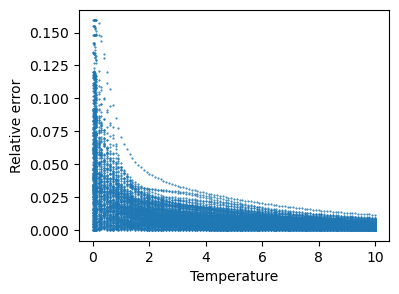

PyObject Text(24.0, 0.5, 'Relative error')

In [183]:
PyPlot.plot(
    df.temperature,
    abs.(df.dense_partition - df.sparse_partition) ./ (0.5 * (df.dense_partition + df.sparse_partition)),
    ".",
    markersize=1,
)
PyPlot.xlabel("Temperature")
PyPlot.ylabel("Relative error")

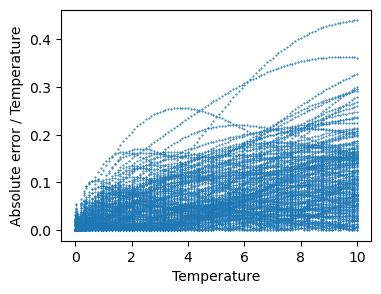

PyObject Text(24.000000000000007, 0.5, 'Absolute error / Temperature')

In [184]:
PyPlot.plot(
    df.temperature,
    abs.(df.dense_energy - df.sparse_energy) ./ df.temperature,
    ".",
    markersize=1,
)
PyPlot.xlabel("Temperature")
PyPlot.ylabel("Absolute error / Temperature")

In [185]:
using Statistics
PyPlot.rc("figure", figsize=(4,3))

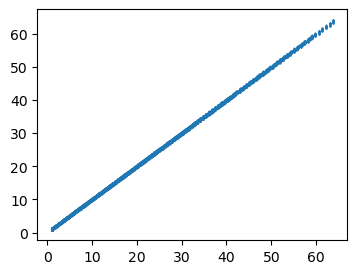

cor(df.dense_partition, df.sparse_partition) = 0.9999591988773142


0.9999591988773142

In [186]:
PyPlot.plot(df.dense_partition, df.sparse_partition, ".", markersize=1)
@show cor(df.dense_partition, df.sparse_partition)

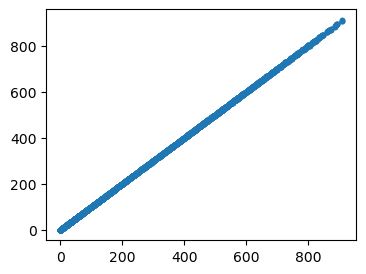

cor(df.dense_energy, df.sparse_energy) = 0.9999959327792921


0.9999959327792921

In [187]:
PyPlot.plot(df.dense_energy, df.sparse_energy, ".")
@show cor(df.dense_energy, df.sparse_energy)

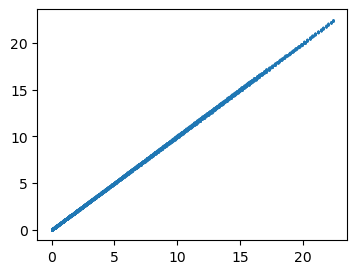

cor(df.dense_energy ./ df.dense_partition, df.sparse_energy ./ df.sparse_partition) = 0.9999741120459129


0.9999741120459129

In [188]:
PyPlot.plot(df.dense_energy ./ df.dense_partition, df.sparse_energy ./ df.sparse_partition, ".", markersize=1)
@show cor(df.dense_energy ./ df.dense_partition, df.sparse_energy ./ df.sparse_partition)

In [189]:
x = []
y = []
for row in eachrow(df)
    Sx_dense = JSON.parse(row.dense_spin_correlation)
    Sx_sparse = JSON.parse(row.sparse_spin_correlation)
    push!(x, Sx_dense)
    push!(y, Sx_sparse)
end
x = hcat(x...)
y = hcat(y...)

3×17440 Matrix{Float64}:
  0.356191    0.390259    0.403438   …   6.5608     6.6542     6.74809
 -0.0554633  -0.0577802  -0.0586764     -0.762635  -0.774044  -0.785516
 -0.0117057  -0.0217891  -0.0256895     -0.992497  -1.00497   -1.0175

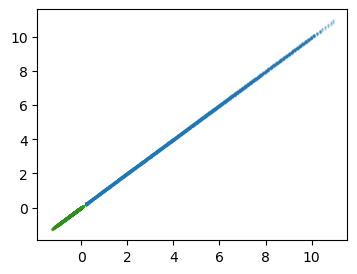

cor(x[1, :], y[1, :]) = 0.9999437147448627
cor(x[2, :], y[2, :]) = 0.999882180271154
cor(x[3, :], y[3, :]) = 0.999370178505631


In [190]:
PyPlot.plot(x[1,:], y[1,:], ".", alpha=0.1, markersize=1)
@show cor(x[1,:], y[1,:])
PyPlot.plot(x[2,:], y[2,:], ".", alpha=0.1, markersize=1)
@show cor(x[2,:], y[2,:])
PyPlot.plot(x[3,:], y[3,:], ".", alpha=0.1, markersize=1)
@show cor(x[3,:], y[3,:])
;